### Notebook to be used to perform focus sweep using X images, then processing them to find the best focus. In this case we're using the 0th order image but this can be modified.

In [1]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]

import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.afw.display as afwDisplay
#afwDisplay.setDefaultBackend('firefly')
afwDisplay.setDefaultBackend('matplotlib')
import time
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.geom

import os
import lsst.log
lsst.log.usePythonLogging()

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')

In [2]:
# Setup the butler
accs_images = True
if accs_images:
    repo = os.path.join("/home/saluser/ingest/accs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
else:
    repo = os.path.join("/home/saluser/ingest/dmcs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
#raw = butler.get("raw", visit=2019053100020)
#image = raw.getImage().array

2019-11-14 16:28:00,945 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-14 16:28:00,946 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


In [3]:
#Setup the remotes
d = salobj.Domain()
ATArchiver = salobj.Remote(d, 'ATArchiver')
#await ATArchiver.start_task
ATCamera = salobj.Remote(d, 'ATCamera')
#await ATCamera.start_task
LinearStage1 = salobj.Remote(d, 'LinearStage',1)
#await LinearStage1.start_task
ATSpectrograph = salobj.Remote(d, 'ATSpectrograph')
await asyncio.gather(ATArchiver.start_task, ATCamera.start_task, 
                     LinearStage1.start_task, ATSpectrograph.start_task)

2019-11-14 16:28:21,295 ATArchiver   INFO     Read historical data in 11.85 sec
2019-11-14 16:28:21,440 LinearStage  INFO     Read historical data in 11.99 sec
2019-11-14 16:28:21,678 ATSpectrograph INFO     Read historical data in 12.22 sec
2019-11-14 16:28:21,954 ATCamera     INFO     Read historical data in 12.51 sec


[None, None, None, None]

### Leave this cell for state transitions 

In [66]:
await LinearStage1.evt_heartbeat.next(flush=True, timeout=5)

In [67]:
await salobj.set_summary_state(LinearStage1, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

## Setup ATSpectograph

In [79]:
from lsst.ts.standardscripts.auxtel.latiss import LATISS

latiss = LATISS(salobj.Remote(domain=d, name="ATCamera"), 
                salobj.Remote(domain=d, name="ATSpectrograph"))

await asyncio.gather(latiss.atcam.start_task, latiss.atspec.start_task)

2019-11-13 22:34:15,126 ATSpectrograph INFO     Read historical data in 0.44 sec
2019-11-13 22:34:15,371 ATCamera     INFO     Read historical data in 0.68 sec


[None, None]

In [87]:
tmp = latiss.atspec.evt_settingsApplied.get()
print('filter names: {}'.format(tmp.filterNames))
print('grating names: {}'.format(tmp.gratingNames))

filter names: empty_1,empty_2,disperser,empty_3
grating names: empty,ronchi170lpmm,ronchi90lpmm,holo_etu1


In [88]:
#await latiss.setup_atspec(filter='empty_1', grating='ronchi90lpmm')

await latiss.setup_atspec(filter='empty_1', grating='empty')

2019-11-13 22:40:28,248 LinearStage  WARNING  RemoteEvent(LinearStage, 1, heartbeat) falling behind; read 100 messages
2019-11-13 22:40:28,345 LinearStage  WARNING  RemoteEvent(LinearStage, 1, heartbeat) falling behind; read 100 messages
2019-11-13 22:40:28,423 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-13 22:40:28,500 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-13 22:40:28,576 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-13 22:40:28,651 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 100 messages
2019-11-13 22:40:28,724 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 100 messages
2019-11-13 22:40:28,831 LinearStage  WARNING  RemoteTelemetry(LinearStage, 1, position) falling behind; read 100 messages
2019-11-13 22:40:28,955 Linea

## Setup Monochromator

In [6]:
wavelength = 455

In [7]:
# ATMonochromator.cmd_changeWavelength.set(wavelength=wavelength)
# try:
#     asyncio.get_event_loop().run_until_complete(ATMonochromator.cmd_changeWavelength.start())
# except AckError as ack_err:
#     print(f"Failed with ack.result={ack_err.ack.result}")

In [8]:
#ATMonochromator.cmd_selectGrating.set(gratingType=0)
#asyncio.get_event_loop().run_until_complete(ATMonochromator.cmd_selectGrating.start())

In [9]:
#ATMonochromator.cmd_changeSlitWidth.set(slitWidth=0.2,
#                          slit=SALPY_ATMonochromator.ATMonochromator_shared_Slit_FrontEntrance)
#asyncio.get_event_loop().run_until_complete(ATMonochromator.cmd_changeSlitWidth.start())

In [10]:
#ATMonochromator.cmd_changeSlitWidth.set(slitWidth=0.2,
#                          slit=SALPY_ATMonochromator.ATMonochromator_shared_Slit_FrontExit)
#asyncio.get_event_loop().run_until_complete(ATMonochromator.cmd_changeSlitWidth.start())

## Setup the Linear Stage (focuser)

In [39]:
pos=None
pos=await LinearStage1.tel_position.next(flush=True, timeout=5)
print('Current stage position is {:0.4f} [mm]'.format(pos.position))

Current stage position is 28.0000 [mm]


In [36]:
# Home the stage (only necessary if power was off)
if True:
    await LinearStage1.cmd_getHome.start()
else:
    print('Ignoring')

2019-11-13 21:59:51,265 LinearStage  WARNING  RemoteTelemetry(LinearStage, 1, position) falling behind; read 44 messages
2019-11-13 21:59:51,303 LinearStage  WARNING  RemoteTelemetry(LinearStage, 1, position) falling behind; read 44 messages
2019-11-13 21:59:51,337 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 25 messages
2019-11-13 21:59:51,356 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 25 messages
2019-11-13 21:59:51,375 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 24 messages
2019-11-13 21:59:51,395 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 24 messages
2019-11-13 21:59:51,417 LinearStage  WARNING  RemoteEvent(LinearStage, 1, heartbeat) falling behind; read 24 messages
2019-11-13 21:59:51,442 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 69 messages
2019-11-13 21:59:51,507 ATSpectrogra

In [100]:
# Move the stage
lin_stage_pos=28.62-18.8
lin_stage_pos=28.62-20.5
lin_stage_pos = 30.0+2 -2 + 4
await LinearStage1.cmd_moveAbsolute.set_start(distance=lin_stage_pos)


2019-11-14 18:04:12,987 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-14 18:04:13,065 LinearStage  WARNING  RemoteTelemetry(LinearStage, 1, position) falling behind; read 100 messages
2019-11-14 18:04:13,145 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 78 messages
2019-11-14 18:04:13,211 LinearStage  WARNING  RemoteEvent(LinearStage, 1, heartbeat) falling behind; read 77 messages
2019-11-14 18:04:13,270 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 79 messages


In [100]:
wavelength=455
# 33 is best focus for 0th order for grating and no filter (632nm)
# 33.85 best forcus for 0th order for no grating and no filter (632nm)

# 27.0 is best focus for 0th order for grating and no filter (632nm)

focus_center=28.62
dx=7.
step=2.0
focus_demands = np.arange(focus_center-dx, focus_center+dx, step)
#focus_vals = np.arange(68.4, 71.3, 0.3) - coarse
print(focus_demands)

[21.62 23.62 25.62 27.62 29.62 31.62 33.62 35.62]


In [101]:
image_list=[]
focus_vals=np.empty(len(focus_demands))
for i,lin_stage_pos in enumerate(focus_demands):
    print('Setting focus of {} [mm]'.format(lin_stage_pos))
    
    # Move focus stage
    await LinearStage1.cmd_moveAbsolute.set_start(distance=lin_stage_pos)
    
    focus_vals[i]=(await LinearStage1.tel_position.next(flush=True, timeout=5)).position
    #print('Linear stage demand {}, actual {}:'.format(lin_stage_pos, focus_vals[i]))
    #assert lin_stage_pos == focus_vals[i], "Linear stage commanded {} versus actual {} positions are not consistent".format(lin_stage_pos, focus_vals[i])
    
    # Take image
    group_id='wave,Focus,'+str(wavelength)+','+str(lin_stage_pos)+'PH=5um'
    expTime=0.5
    
    # flush event cache
    ATCamera.evt_endReadout.flush()
    if accs_images == False:
        ATArchiver.evt_processingStatus.flush() 
    
    await ATCamera.cmd_takeImages.set_start(expTime=expTime, shutter=1, numImages=1, 
                                imageType='OBJECT', groupId=group_id)
    endReadout = await ATCamera.evt_endReadout.next(flush=False, timeout=10)
    
    print('ACCS Wrote file {}'.format(endReadout.imageName) )
    
#     if accs_images == False:
#         # wait for Archiver
#         processingStatus = await ATArchiver.evt_processingStatus.next(flush=False, timeout=30)
#         print(processingStatus.description)
    
    image_list.append(endReadout.imageName)

2019-11-13 22:46:10,291 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-13 22:46:10,371 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-13 22:46:10,444 ATCamera     WARNING  RemoteTelemetry(ATCamera, 0, wrebPower) falling behind; read 17 messages


Setting focus of 21.62 [mm]


2019-11-13 22:46:10,529 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-13 22:46:10,864 ATCamera     WARNING  RemoteTelemetry(ATCamera, 0, wreb) falling behind; read 17 messages
2019-11-13 22:46:10,940 LinearStage  WARNING  RemoteEvent(LinearStage, 1, heartbeat) falling behind; read 100 messages
2019-11-13 22:46:11,086 ATCamera     WARNING  RemoteTelemetry(ATCamera, 0, wrebPower) falling behind; read 17 messages
2019-11-13 22:46:11,105 ATCamera     WARNING  RemoteTelemetry(ATCamera, 0, wrebPower) falling behind; read 17 messages
2019-11-13 22:46:11,120 ATCamera     WARNING  RemoteTelemetry(ATCamera, 0, vacuum) falling behind; read 17 messages
2019-11-13 22:46:11,134 LinearStage  WARNING  RemoteEvent(LinearStage, 1, heartbeat) falling behind; read 100 messages
2019-11-13 22:46:11,209 ATCamera     WARNING  RemoteTelemetry(ATCamera, 0, wreb) falling behind; read 17 messages
2019-11-13 22:46:11,223 ATCamera     WARNING  RemoteTel

ACCS Wrote file AT_O_20191113_000069
Setting focus of 23.62 [mm]
ACCS Wrote file AT_O_20191113_000070
Setting focus of 25.62 [mm]
ACCS Wrote file AT_O_20191113_000071
Setting focus of 27.62 [mm]
ACCS Wrote file AT_O_20191113_000072
Setting focus of 29.62 [mm]
ACCS Wrote file AT_O_20191113_000073
Setting focus of 31.62 [mm]
ACCS Wrote file AT_O_20191113_000074
Setting focus of 33.620000000000005 [mm]
ACCS Wrote file AT_O_20191113_000075
Setting focus of 35.620000000000005 [mm]
ACCS Wrote file AT_O_20191113_000076


In [102]:
for index, img in enumerate(image_list):
    print('{}, {:0.2f}'.format(img, focus_vals[index]))

AT_O_20191113_000069, 21.62
AT_O_20191113_000070, 23.62
AT_O_20191113_000071, 25.62
AT_O_20191113_000072, 27.62
AT_O_20191113_000073, 29.62
AT_O_20191113_000074, 31.62
AT_O_20191113_000075, 33.62
AT_O_20191113_000076, 35.62


In [103]:
import importlib
import utils.processExposure 
importlib.reload(utils.processExposure)
from utils.processExposure import processExposure


import utils.grabATImage 
importlib.reload(utils.grabATImage)
from utils.grabATImage import grabATImage

In [104]:
# # parse out visitID from filename - this is highly annoying
# tmp=endReadout.imageName.split('_')
# prefix=tmp[2] # dayobs without the dashes

# # Don't remember why I used int here... whitespace? 
# # surely fixable but bigger fish.
# suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
# visitID = int((prefix+suffix))
# dataId1 = {'visit': visitID}
# print(visitID)

# # Grab image from butler, but need to wait to ingestion so use this polling function
# exposure = await grabATImage(visitID, repo, timeout = 40, poll_freq_hz=2)

# # do ISR correction
# isr_corr_exposure = processExposure(exposure, repo=repo)

In [105]:
# Only here for me to debug, should be up top with other declarations
import importlib
import utils.findNarrowbandRonchiPeaks
importlib.reload(utils.findNarrowbandRonchiPeaks)
from utils.findNarrowbandRonchiPeaks import findNarrowbandRonchiPeaks

import utils.fitExposure
importlib.reload(utils.fitExposure)
from utils.fitExposure import fit2DGaussian

import utils.calc_CofM
importlib.reload(utils.calc_CofM)
from utils.calc_CofM import calc_CofM

import utils.calc_encircled_energy
importlib.reload(utils.calc_encircled_energy)
from utils.calc_encircled_energy import calc_encircled_energy

In [106]:
# Source detection libraries
from lsst.meas.algorithms.detection import SourceDetectionTask
import lsst.afw.table as afwTable

# create the output table for source detection
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10  # detection threshold after smoothing
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

2019-11-13 22:47:46,578 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:47:46,579 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Processing file 0 of 8, filename=AT_O_20191113_000069, focus=21.6200008392334


2019-11-13 22:47:47,512 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300069}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 22:47:47,697 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 22:47:47,700 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 22:47:47,701 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300069}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 22:47:47,701 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
2019-11-13 22:47:47,772 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-1

Exposure retrieved after waiting 1.19 [s]


2019-11-13 22:47:49,007 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
/opt/lsst/software/stack/stack/miniconda3-4.5.12-4d7b902/Linux64/pex_config/18.1.0-5-gc286bb7+4/python/lsst/pex/config/config.py:1279: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
2019-11-13 22:47:49,010 isr          INFO     Converting exposure to floating point values.
2019-11-13 22:47:49,293 isr          INFO     Assembling CCD from amplifiers.
2019-11-13 22:47:49,418 isr          WARNING  No WCS found in input exposure.
2019-11-13 22:47:49,419 isr          INFO     Applying bias correction.
2019-11-13 22:47:49,920 isr          INFO     Masking NAN value pixels.
2019-11-13 22:47:49,948 isr      

Time to perform image ISR was 2.026527 [s]


2019-11-13 22:47:51,436 sourceDetection INFO     Detected 1 positive peaks in 1 footprints and 0 negative peaks in 0 footprints to 10 sigma
2019-11-13 22:47:51,436 sourceDetection.background WARNING  Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(4, 32) < 6]
2019-11-13 22:47:51,437 sourceDetection.background WARNING  Reducing approxOrder to 3
2019-11-13 22:47:51,494 sourceDetection INFO     Resubtracting the background after object detection
2019-11-13 22:47:51,508 findNarrowbandRonchiPeak_logger INFO     Zeroth order peak is at 2097, 2254
2019-11-13 22:47:51,509 findNarrowbandRonchiPeak_logger INFO     Dispersion set to None, returning only center source
2019-11-13 22:47:51,558 calc_CofM_logger INFO     x_CofM is 2096.913670810609
2019-11-13 22:47:51,558 calc_CofM_logger INFO     y_CofM is 2253.2868685219455
2019-11-13 22:47:51,559 calc_encirlced_energy_logger INFO     x_CofM is 2096.913670810609
2019-11-13 22:47:51,559 calc_encirlced_energy_logger INFO     y

<Gaussian2D(amplitude=4618.2689807, x_mean=2096.86494074, y_mean=2253.69367843, x_stddev=4.15353565, y_stddev=3.83399677, theta=0.)>


2019-11-13 22:47:51,902 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [6.767, 9.854, 13.022] pixels
2019-11-13 22:47:51,974 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:47:51,975 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Processing file 1 of 8, filename=AT_O_20191113_000070, focus=23.6200008392334


2019-11-13 22:47:52,979 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300070}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 22:47:53,180 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 22:47:53,183 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 22:47:53,184 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300070}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 22:47:53,184 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.


Exposure retrieved after waiting 1.28 [s]


2019-11-13 22:47:53,424 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:47:53,425 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3
2019-11-13 22:47:54,601 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
/opt/lsst/software/stack/stack/miniconda3-4.5.12-4d7b902/Linux64/pex_config/18.1.0-5-gc286bb7+4/python/lsst/pex/config/config.py:1279: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
2019-11-13 22:47:54,602 isr          INFO     Converting exposure to floating point values.
2019-11-13 22:47:54,885 isr          INFO     Assembling CCD from amplifiers.
2019-11

Time to perform image ISR was 2.023604 [s]


2019-11-13 22:47:57,013 sourceDetection INFO     Detected 1 positive peaks in 1 footprints and 0 negative peaks in 0 footprints to 10 sigma
2019-11-13 22:47:57,014 sourceDetection.background WARNING  Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(4, 32) < 6]
2019-11-13 22:47:57,015 sourceDetection.background WARNING  Reducing approxOrder to 3
2019-11-13 22:47:57,070 sourceDetection INFO     Resubtracting the background after object detection
2019-11-13 22:47:57,085 findNarrowbandRonchiPeak_logger INFO     Zeroth order peak is at 2102, 2253
2019-11-13 22:47:57,085 findNarrowbandRonchiPeak_logger INFO     Dispersion set to None, returning only center source
2019-11-13 22:47:57,139 calc_CofM_logger INFO     x_CofM is 2101.613128439135
2019-11-13 22:47:57,140 calc_CofM_logger INFO     y_CofM is 2252.3328170481473
2019-11-13 22:47:57,141 calc_encirlced_energy_logger INFO     x_CofM is 2101.613128439135
2019-11-13 22:47:57,141 calc_encirlced_energy_logger INFO     y

<Gaussian2D(amplitude=10703.91170512, x_mean=2101.64092713, y_mean=2252.74040587, x_stddev=2.53375689, y_stddev=2.27644132, theta=0.)>


2019-11-13 22:47:57,490 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [3.642, 5.734, 7.963] pixels
2019-11-13 22:47:57,556 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:47:57,557 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Processing file 2 of 8, filename=AT_O_20191113_000071, focus=25.6200008392334


2019-11-13 22:47:58,502 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300071}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 22:47:58,674 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 22:47:58,677 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 22:47:58,678 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300071}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 22:47:58,678 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
2019-11-13 22:47:58,770 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-1

Exposure retrieved after waiting 1.19 [s]


2019-11-13 22:47:59,956 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
/opt/lsst/software/stack/stack/miniconda3-4.5.12-4d7b902/Linux64/pex_config/18.1.0-5-gc286bb7+4/python/lsst/pex/config/config.py:1279: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
2019-11-13 22:47:59,958 isr          INFO     Converting exposure to floating point values.
2019-11-13 22:48:00,242 isr          INFO     Assembling CCD from amplifiers.
2019-11-13 22:48:00,369 isr          WARNING  No WCS found in input exposure.
2019-11-13 22:48:00,369 isr          INFO     Applying bias correction.
2019-11-13 22:48:00,848 isr          INFO     Masking NAN value pixels.
2019-11-13 22:48:00,870 isr      

Time to perform image ISR was 2.050370 [s]


2019-11-13 22:48:02,421 sourceDetection INFO     Detected 1 positive peaks in 1 footprints and 0 negative peaks in 0 footprints to 10 sigma
2019-11-13 22:48:02,422 sourceDetection.background WARNING  Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(4, 32) < 6]
2019-11-13 22:48:02,422 sourceDetection.background WARNING  Reducing approxOrder to 3
2019-11-13 22:48:02,477 sourceDetection INFO     Resubtracting the background after object detection
2019-11-13 22:48:02,493 findNarrowbandRonchiPeak_logger INFO     Zeroth order peak is at 2101, 2250
2019-11-13 22:48:02,494 findNarrowbandRonchiPeak_logger INFO     Dispersion set to None, returning only center source
2019-11-13 22:48:02,550 calc_CofM_logger INFO     x_CofM is 2100.6007032329408
2019-11-13 22:48:02,551 calc_CofM_logger INFO     y_CofM is 2249.584203450144
2019-11-13 22:48:02,552 calc_encirlced_energy_logger INFO     x_CofM is 2100.6007032329408
2019-11-13 22:48:02,553 calc_encirlced_energy_logger INFO     

<Gaussian2D(amplitude=26172.40450778, x_mean=2100.67816284, y_mean=2249.94200433, x_stddev=1.5723524, y_stddev=1.45835353, theta=0.)>


2019-11-13 22:48:02,904 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [1.666, 2.789, 4.296] pixels
2019-11-13 22:48:02,970 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:48:02,972 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Processing file 3 of 8, filename=AT_O_20191113_000072, focus=27.6200008392334


2019-11-13 22:48:03,882 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300072}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 22:48:04,057 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 22:48:04,061 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 22:48:04,062 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300072}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 22:48:04,064 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
2019-11-13 22:48:04,156 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-1

Exposure retrieved after waiting 1.16 [s]


2019-11-13 22:48:05,447 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
/opt/lsst/software/stack/stack/miniconda3-4.5.12-4d7b902/Linux64/pex_config/18.1.0-5-gc286bb7+4/python/lsst/pex/config/config.py:1279: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
2019-11-13 22:48:05,449 isr          INFO     Converting exposure to floating point values.
2019-11-13 22:48:05,729 isr          INFO     Assembling CCD from amplifiers.
2019-11-13 22:48:05,853 isr          WARNING  No WCS found in input exposure.
2019-11-13 22:48:05,853 isr          INFO     Applying bias correction.
2019-11-13 22:48:06,348 isr          INFO     Masking NAN value pixels.
2019-11-13 22:48:06,370 isr      

Time to perform image ISR was 1.999656 [s]
<Gaussian2D(amplitude=51027.85231125, x_mean=2101.41459654, y_mean=2248.0780337, x_stddev=1.17382366, y_stddev=1.14875694, theta=0.)>


2019-11-13 22:48:08,319 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [1.890, 3.279, 5.431] pixels
2019-11-13 22:48:08,392 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:48:08,393 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Processing file 4 of 8, filename=AT_O_20191113_000073, focus=29.6200008392334


2019-11-13 22:48:09,309 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300073}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 22:48:09,470 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 22:48:09,473 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 22:48:09,474 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300073}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 22:48:09,475 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
2019-11-13 22:48:09,562 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-1

Exposure retrieved after waiting 1.16 [s]


2019-11-13 22:48:10,804 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
/opt/lsst/software/stack/stack/miniconda3-4.5.12-4d7b902/Linux64/pex_config/18.1.0-5-gc286bb7+4/python/lsst/pex/config/config.py:1279: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
2019-11-13 22:48:10,805 isr          INFO     Converting exposure to floating point values.
2019-11-13 22:48:11,105 isr          INFO     Assembling CCD from amplifiers.
2019-11-13 22:48:11,230 isr          WARNING  No WCS found in input exposure.
2019-11-13 22:48:11,230 isr          INFO     Applying bias correction.
2019-11-13 22:48:11,713 isr          INFO     Masking NAN value pixels.
2019-11-13 22:48:11,737 isr      

Time to perform image ISR was 1.999276 [s]
<Gaussian2D(amplitude=61195.03414972, x_mean=2103.81777869, y_mean=2246.87264448, x_stddev=1.08596806, y_stddev=1.13545154, theta=0.)>


2019-11-13 22:48:13,653 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [1.557, 2.423, 3.736] pixels
2019-11-13 22:48:13,718 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:48:13,719 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Processing file 5 of 8, filename=AT_O_20191113_000074, focus=31.6200008392334


2019-11-13 22:48:14,660 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300074}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 22:48:14,826 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 22:48:14,829 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 22:48:14,830 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300074}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 22:48:14,830 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
2019-11-13 22:48:14,914 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-1

Exposure retrieved after waiting 1.18 [s]


2019-11-13 22:48:16,081 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
/opt/lsst/software/stack/stack/miniconda3-4.5.12-4d7b902/Linux64/pex_config/18.1.0-5-gc286bb7+4/python/lsst/pex/config/config.py:1279: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
2019-11-13 22:48:16,083 isr          INFO     Converting exposure to floating point values.
2019-11-13 22:48:16,414 isr          INFO     Assembling CCD from amplifiers.
2019-11-13 22:48:16,564 isr          WARNING  No WCS found in input exposure.
2019-11-13 22:48:16,565 isr          INFO     Applying bias correction.
2019-11-13 22:48:17,083 isr          INFO     Masking NAN value pixels.
2019-11-13 22:48:17,104 isr      

Time to perform image ISR was 2.069640 [s]


2019-11-13 22:48:18,550 sourceDetection INFO     Detected 1 positive peaks in 1 footprints and 0 negative peaks in 0 footprints to 10 sigma
2019-11-13 22:48:18,551 sourceDetection.background WARNING  Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(4, 32) < 6]
2019-11-13 22:48:18,552 sourceDetection.background WARNING  Reducing approxOrder to 3
2019-11-13 22:48:18,615 sourceDetection INFO     Resubtracting the background after object detection
2019-11-13 22:48:18,630 findNarrowbandRonchiPeak_logger INFO     Zeroth order peak is at 2106, 2247
2019-11-13 22:48:18,630 findNarrowbandRonchiPeak_logger INFO     Dispersion set to None, returning only center source
2019-11-13 22:48:18,682 calc_CofM_logger INFO     x_CofM is 2105.8961700878117
2019-11-13 22:48:18,683 calc_CofM_logger INFO     y_CofM is 2246.821084937116
2019-11-13 22:48:18,684 calc_encirlced_energy_logger INFO     x_CofM is 2105.8961700878117
2019-11-13 22:48:18,684 calc_encirlced_energy_logger INFO     

<Gaussian2D(amplitude=34218.38441039, x_mean=2105.72238945, y_mean=2246.99513635, x_stddev=1.47110387, y_stddev=1.60430981, theta=0.)>


2019-11-13 22:48:19,053 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [2.089, 3.042, 4.063] pixels
2019-11-13 22:48:19,119 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:48:19,120 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Processing file 6 of 8, filename=AT_O_20191113_000075, focus=33.619876861572266


2019-11-13 22:48:20,067 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300075}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 22:48:20,244 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 22:48:20,251 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 22:48:20,254 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300075}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 22:48:20,257 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
2019-11-13 22:48:20,414 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-1

Exposure retrieved after waiting 1.21 [s]


2019-11-13 22:48:21,744 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
/opt/lsst/software/stack/stack/miniconda3-4.5.12-4d7b902/Linux64/pex_config/18.1.0-5-gc286bb7+4/python/lsst/pex/config/config.py:1279: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
2019-11-13 22:48:21,746 isr          INFO     Converting exposure to floating point values.
2019-11-13 22:48:22,034 isr          INFO     Assembling CCD from amplifiers.
2019-11-13 22:48:22,165 isr          WARNING  No WCS found in input exposure.
2019-11-13 22:48:22,166 isr          INFO     Applying bias correction.
2019-11-13 22:48:22,661 isr          INFO     Masking NAN value pixels.
2019-11-13 22:48:22,683 isr      

Time to perform image ISR was 2.032098 [s]


2019-11-13 22:48:24,318 calc_CofM_logger INFO     x_CofM is 2107.1014437627227
2019-11-13 22:48:24,319 calc_CofM_logger INFO     y_CofM is 2246.718538671179
2019-11-13 22:48:24,320 calc_encirlced_energy_logger INFO     x_CofM is 2107.1014437627227
2019-11-13 22:48:24,320 calc_encirlced_energy_logger INFO     y_CofM is 2246.718538671179


<Gaussian2D(amplitude=13236.42267726, x_mean=2106.82507861, y_mean=2246.9700126, x_stddev=2.51311806, y_stddev=2.75406696, theta=0.)>


2019-11-13 22:48:24,654 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [3.215, 4.373, 5.591] pixels
2019-11-13 22:48:24,717 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 22:48:24,717 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Processing file 7 of 8, filename=AT_O_20191113_000076, focus=35.619876861572266


2019-11-13 22:48:25,639 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300076}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 22:48:25,800 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 22:48:25,803 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 22:48:25,804 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300076}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 22:48:25,805 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
2019-11-13 22:48:25,892 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-1

Exposure retrieved after waiting 1.15 [s]


2019-11-13 22:48:27,125 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
/opt/lsst/software/stack/stack/miniconda3-4.5.12-4d7b902/Linux64/pex_config/18.1.0-5-gc286bb7+4/python/lsst/pex/config/config.py:1279: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
2019-11-13 22:48:27,127 isr          INFO     Converting exposure to floating point values.
2019-11-13 22:48:27,412 isr          INFO     Assembling CCD from amplifiers.
2019-11-13 22:48:27,537 isr          WARNING  No WCS found in input exposure.
2019-11-13 22:48:27,538 isr          INFO     Applying bias correction.
2019-11-13 22:48:28,032 isr          INFO     Masking NAN value pixels.
2019-11-13 22:48:28,053 isr      

Time to perform image ISR was 2.012633 [s]


2019-11-13 22:48:29,526 sourceDetection INFO     Detected 1 positive peaks in 1 footprints and 0 negative peaks in 0 footprints to 10 sigma
2019-11-13 22:48:29,527 sourceDetection.background WARNING  Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(4, 32) < 6]
2019-11-13 22:48:29,527 sourceDetection.background WARNING  Reducing approxOrder to 3
2019-11-13 22:48:29,585 sourceDetection INFO     Resubtracting the background after object detection
2019-11-13 22:48:29,600 findNarrowbandRonchiPeak_logger INFO     Zeroth order peak is at 2107, 2246
2019-11-13 22:48:29,601 findNarrowbandRonchiPeak_logger INFO     Dispersion set to None, returning only center source
2019-11-13 22:48:29,650 calc_CofM_logger INFO     x_CofM is 2107.237843870956
2019-11-13 22:48:29,651 calc_CofM_logger INFO     y_CofM is 2245.172249311361
2019-11-13 22:48:29,652 calc_encirlced_energy_logger INFO     x_CofM is 2107.237843870956
2019-11-13 22:48:29,652 calc_encirlced_energy_logger INFO     y_

<Gaussian2D(amplitude=5704.83971455, x_mean=2106.87958441, y_mean=2245.54091759, x_stddev=4.07848913, y_stddev=4.3418952, theta=0.)>


2019-11-13 22:48:30,016 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [4.876, 6.132, 7.442] pixels
2019-11-13 22:48:30,043 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 82 messages
2019-11-13 22:48:30,102 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 82 messages
2019-11-13 22:48:30,168 LinearStage  WARNING  RemoteTelemetry(LinearStage, 1, position) falling behind; read 100 messages
2019-11-13 22:48:30,241 LinearStage  WARNING  RemoteTelemetry(LinearStage, 1, position) falling behind; read 100 messages
2019-11-13 22:48:30,323 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-13 22:48:30,401 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
2019-11-13 22:48:30,475 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages


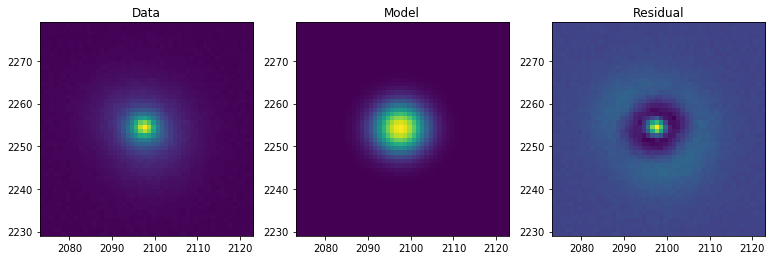

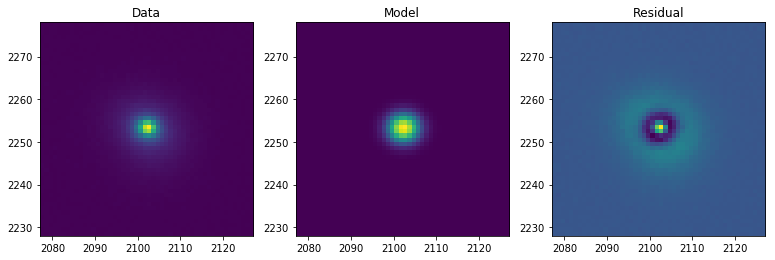

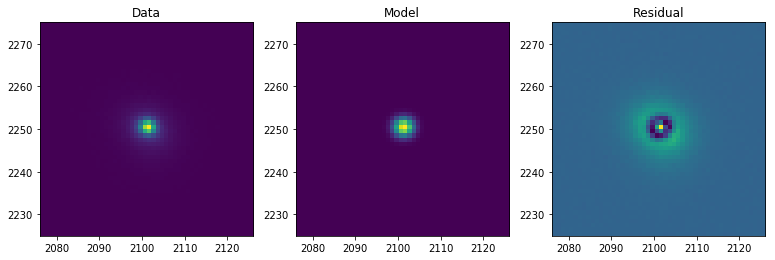

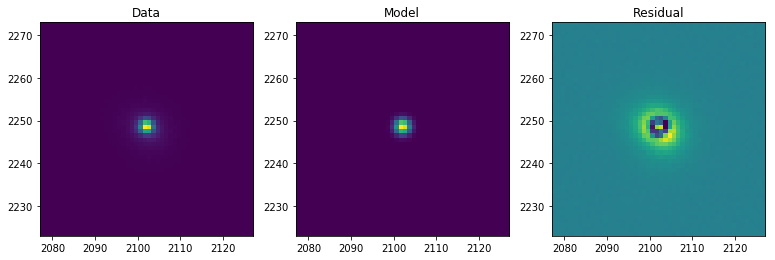

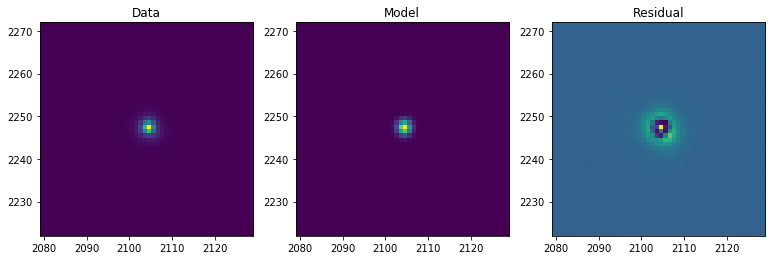

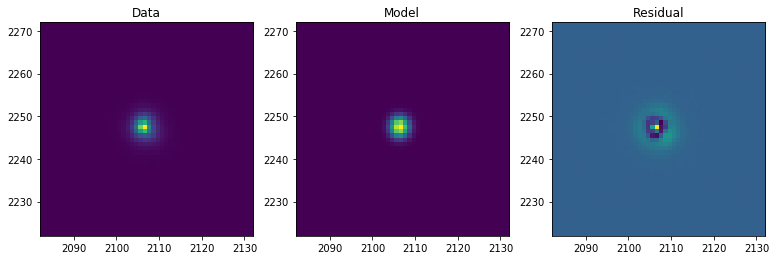

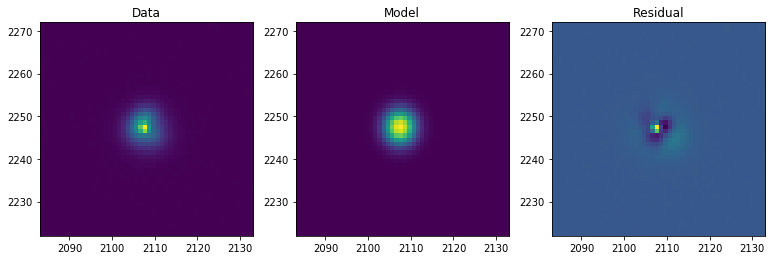

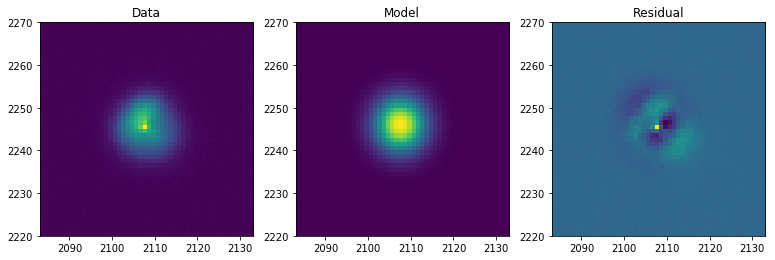

In [107]:
# I don't like looping but I don't know how to handle multiple files yet!
# Declare approximation of where the zero-order star is
zeroth_order_estimate = lsst.geom.Point2D(1700,1960)
zeroth_order_estimate = lsst.geom.Point2D(2075,2025) # low res grating
zeroth_order_estimate = lsst.geom.Point2D(2260,2050) #empty (632)
zeroth_order_estimate = lsst.geom.Point2D(2010,2175) #empty (455)
zeroth_order_star_BBox= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(200,200)) 

fit_data=[]

for index, img_name in enumerate(image_list):
    # parse out visitID from filename - this is highly annoying
    print('Processing file {} of {}, filename={}, focus={}'.format(index,len(image_list), img_name, focus_vals[index]))
    tmp=img_name.split('_')
    prefix=tmp[2] # dayobs without the dashes
    # Don't remember why I used int here... whitespace? 
    # surely fixable but bigger fish.
    suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
    visitID = int((prefix+suffix))
    dataId1 = {'visit': visitID}
    #multi_file_dataset[i]['visitID']=visitID
    
    #exposure = butler.get('raw', **dataId1)
    exposure = await grabATImage(visitID, repo, timeout = 40, poll_freq_hz=2)
    # do ISR correction
    isr_corr_exposure = processExposure(exposure, repo=repo, defects=None) #bias=None
    
    # Find all sources in the image
    tab = afwTable.SourceTable.make(schema)
    # Find the correct sources using just a strip
    search_center_pt = lsst.geom.Point2D(zeroth_order_estimate.getX(),2000)
    search_strip = lsst.geom.Box2I.makeCenteredBox(search_center_pt, lsst.geom.Extent2I(500,3999)) 
    result = sourceDetectionTask.run(tab, isr_corr_exposure[search_strip], sigma=2.0)
    
    # wavelength solution is bad for the fiberSpectrograph, but close enough for this to work
    # can use the monochromator wavelength which is better, but that's not the correct way in the long run

    if False: # display the image in firefly
        plt.close('all')
        disp = afwDisplay.Display(2, reopenPlot=True)
        disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
        disp.setImageColormap('gray')
        disp.scale('linear', 'minmax')
        peak0_subim = isr_corr_exposure.subset(zeroth_order_star_BBox)
        disp.mtv(peak0_subim, title='visit = {}'.format(visitID))        
        #disp.scale('linear', 'zscale')
        #disp.mtv(isr_corr_exposure, title='visit = {}'.format(visitID))
        #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)
        break
        
    
    dispersion = (1/0.6358) # pixels/nm
    spectral_position_angle=0.0107 # radians clockwise from top

    # Find 0th and +/- 1 order peaks 
    sources = result.sources
    
    #center_source, peak1, peak2 = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)
    
    dispersion = None
    center_source = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)
    # Fit peaks
    # zeroth order
    # variables names are weird here because I can't think of a clever way to have -1 and +1 as variable names
    
    bbox0 = lsst.geom.Box2I.makeCenteredBox(center_source.getFootprint().getCentroid(), lsst.geom.Extent2I(50,50)) 
    peak0_subim = isr_corr_exposure.subset(bbox0)
    p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)
    p0_x_CofM, p0_y_CofM = calc_CofM(peak0_subim) # 2167,3372

# Calculate EE and CofM
    p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=False) 
    #fit_data.append(p0_EE_rad67_pix)
    fit_data.append(np.sqrt(p0.x_stddev.value**2 + p0.y_stddev.value**2))
    

#     # offset to test
#     bbox1 = lsst.geom.Box2I.makeCenteredBox(peak1.getFootprint().getCentroid(), lsst.geom.Extent2I(50,50)) 
#     peak1_subim = isr_corr_exposure.subset(bbox1)
#     p1, x1 , y1 = fit2DGaussian(peak1_subim, plot=True)
#     p1_x_CofM, p1_y_CofM = calc_CofM(peak1_subim) # 2167,3372
#     fit_data.append(p1_EE_rad67_pix)

#     # Calculate EE and CofM
#     p1_EE_rad50_pix, p1_EE_rad67_pix, p1_EE_rad80_pix = calc_encircled_energy(peak1_subim, plot=False) 
    
#     fit_data.append(p1_EE_rad80_pix)
#     bbox2 = lsst.geom.Box2I.makeCenteredBox(peak2.getFootprint().getCentroid(), lsst.geom.Extent2I(50,50)) 
#     peak2_subim = isr_corr_exposure.subset(bbox2)
#     p2, x2 , y2 = fit2DGaussian(peak2_subim, plot=False)
#     p2_x_CofM, p2_y_CofM = calc_CofM(peak2_subim) # 2167,3372

#     # Calculate EE and CofM
#     p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=False) 
#     p1_EE_rad50_pix, p1_EE_rad67_pix, p1_EE_rad80_pix = calc_encircled_energy(peak1_subim, plot=False) 
#     p2_EE_rad50_pix, p2_EE_rad67_pix, p2_EE_rad80_pix = calc_encircled_energy(peak2_subim, plot=False) 

#     #  Now use multi_file_dataset
#     multi_file_dataset[i]['Gauss_x_peak'] = (p0.x_mean.value, p1.x_mean.value, p2.x_mean.value)
#     multi_file_dataset[i]['Gauss_y_peak'] = (p0.y_mean.value, p1.y_mean.value, p2.y_mean.value)
#     multi_file_dataset[i]['Gauss_xsigma_pix'] = (p0.x_stddev.value, p1.x_stddev.value, p2.x_stddev.value) 
#     multi_file_dataset[i]['Gauss_ysigma_pix'] = (p0.y_stddev.value, p1.y_stddev.value, p2.y_stddev.value)
#     multi_file_dataset[i]['x_CofM'] = (p0_x_CofM, p1_x_CofM, p2_x_CofM)
#     multi_file_dataset[i]['y_CofM'] = (p0_y_CofM, p1_y_CofM, p2_y_CofM)
#     multi_file_dataset[i]['EE50_pix'] = (p0_EE_rad50_pix, p1_EE_rad50_pix, p2_EE_rad50_pix)
#     multi_file_dataset[i]['EE67_pix'] = (p0_EE_rad67_pix, p1_EE_rad67_pix, p2_EE_rad67_pix)
#     multi_file_dataset[i]['EE80_pix'] = (p0_EE_rad80_pix, p1_EE_rad80_pix, p2_EE_rad80_pix)

In [76]:
np.sqrt(p0.x_stddev.value**2 + p0.y_stddev.value**2)

3.606105736906896

In [98]:
fit_data

[4.172006293957147,
 2.839750485117332,
 2.0390534307684662,
 1.681452691241013,
 1.5460619578775143,
 1.6982280240345407,
 2.29420455147672]

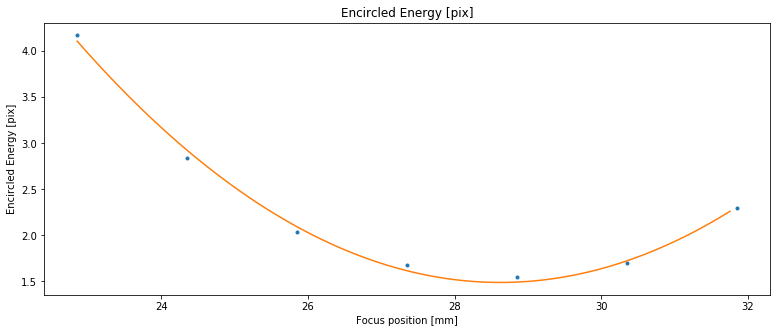

Best focus occurs at 28.624167015401888 [mm]


In [99]:
# Fit a line to the profile
from scipy.optimize import curve_fit


xdata=focus_vals#[0:4]
ydata = fit_data #[3:9]

def parabola(x,b, x0, a):
    return b + a*(x-x0)**2 

popt,pcov = curve_fit(parabola, xdata, ydata)#, p0=[3.0, 75.5 , 1])

plt.close('all')
plt.figure(figsize=(13, 5))
plt.ylabel('Encircled Energy [pix]')
plt.plot(xdata, ydata, '.')
x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
plt.plot(x, parabola(x, *popt))
plt.title('Encircled Energy [pix]')
plt.xlabel('Focus position [mm]')
plt.show()
plt.close()

print('Best focus occurs at {} [mm]'.format(popt[1]))


In [ ]:
26*25.4

In [1]:
pup_diam=25e-3; wave=632e-9
f_coll=113e-3; 

f_tel=550e-3 # 400mm nominal - measured around 25-26 inches
pinhole_diam=2e-6
pix_scl=10 # [um/pix]

diff_limit=1e6*wave/pup_diam*f_coll
print('Diffraction Limit in object space (f=125mm, D=25mm, wave=632nm) is: {0:3f} [um]'.format(diff_limit))
mag=f_tel/f_coll
print('Image diameter of Diffraction Limit is: {0:3f} [um]'.format(mag*diff_limit/pix_scl))
print('Magnification is f_tel/f_col {}:'.format(mag))
im_size=1e6*mag*pinhole_diam
print('Expected image diameter for {0:3f} diameter pinhole: {1:3f} [um]'.format(pinhole_diam*1e6, im_size))
print('80% EE radius in pixels ~{}'.format(im_size/2/pix_scl))

Diffraction Limit in object space (f=125mm, D=25mm, wave=632nm) is: 2.856640 [um]
Image diameter of Diffraction Limit is: 1.390400 [um]
Magnification is f_tel/f_col 4.867256637168142:
Expected image diameter for 2.000000 diameter pinhole: 9.734513 [um]
80% EE radius in pixels ~0.48672566371681414


In [44]:
27*12/550.*2 / 10e-3

117.81818181818181

In [45]:
27*4/550.*2 / 10e-3

39.272727272727266